In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

scene_id=814 scene_name=scene-1074 map_name=singapore-hollandvillage


/home/kfir/workspace/RadarLocalization/dataset.py:376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.54280031e+15 4.60000000e+01]
 [1.54280031e+15 4.60000000e+01]
 [1.54280031e+15 4.60000000e+01]
 ...
 [1.54280057e+15 2.90000000e+01]
 [1.54280057e+15 2.90000000e+01]
 [1.54280057e+15 2.90000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/814/database


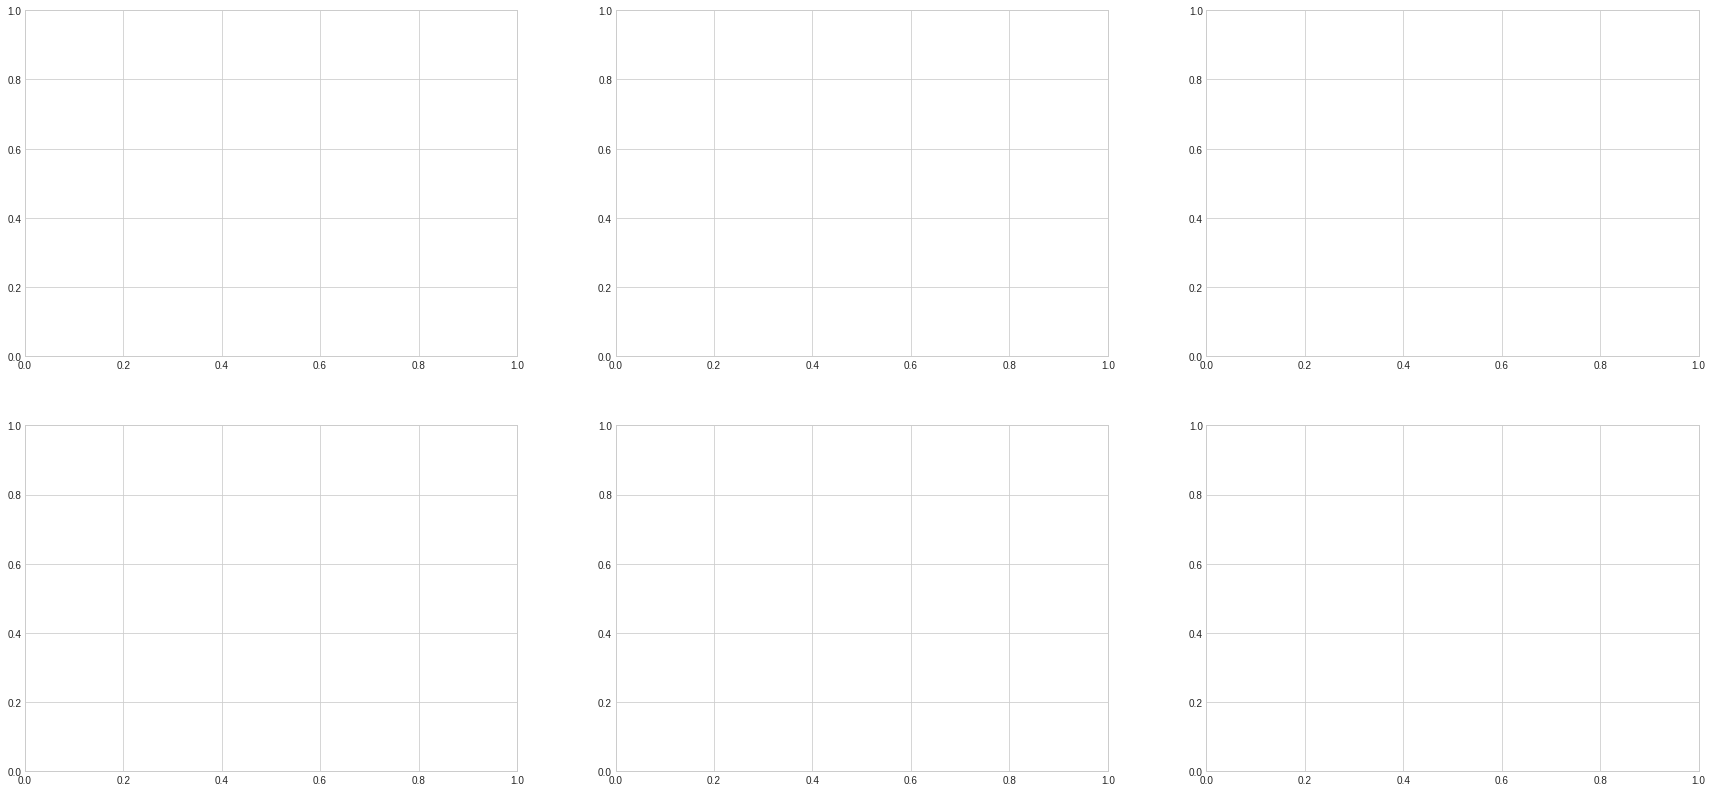

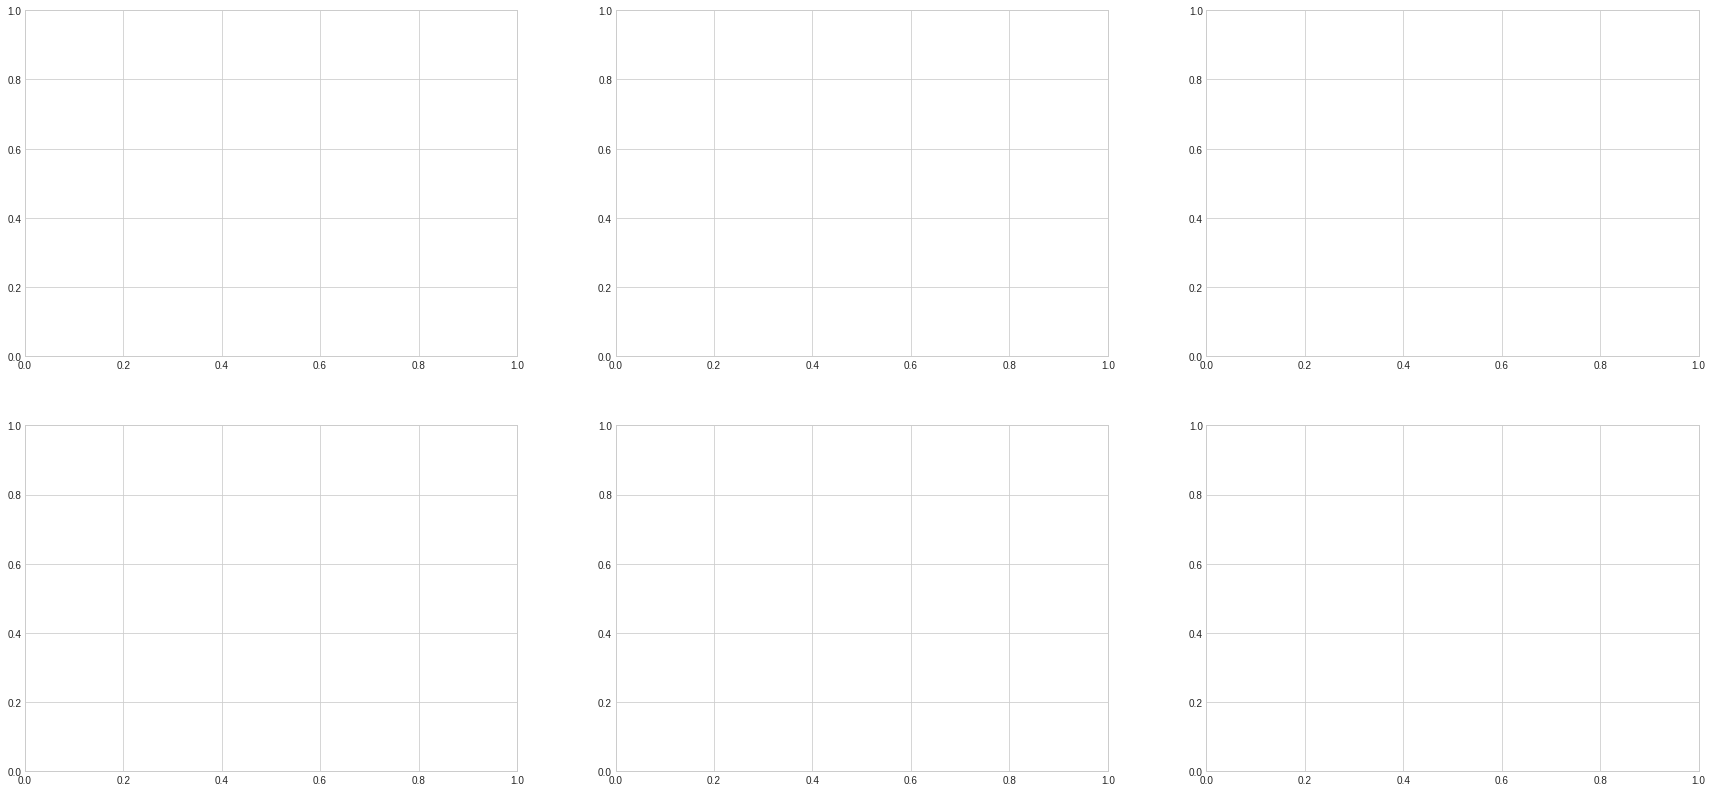

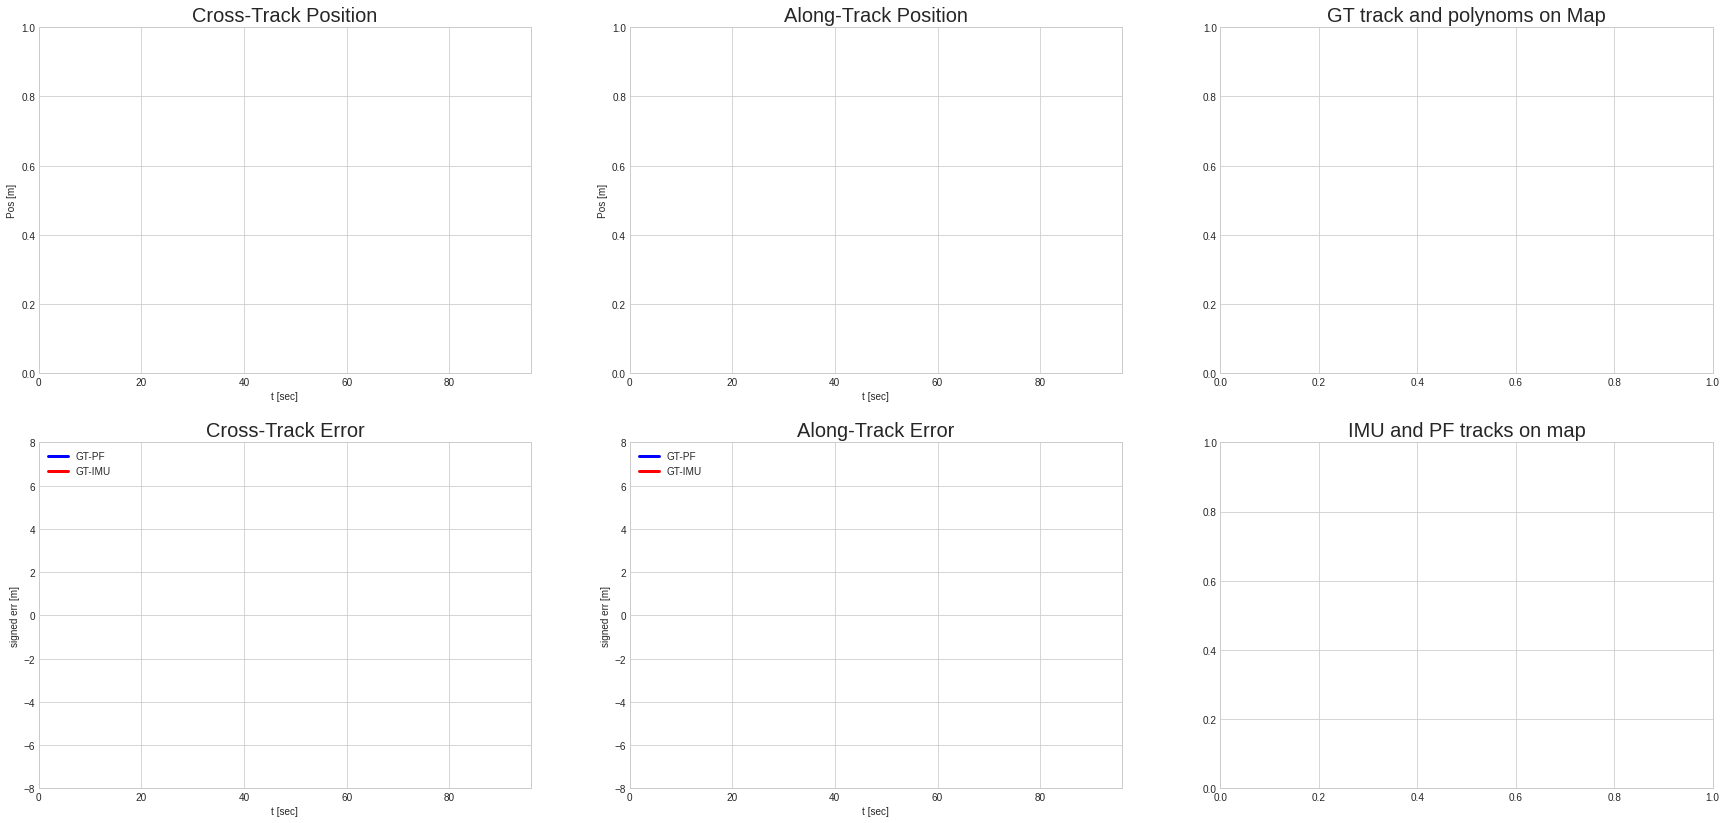

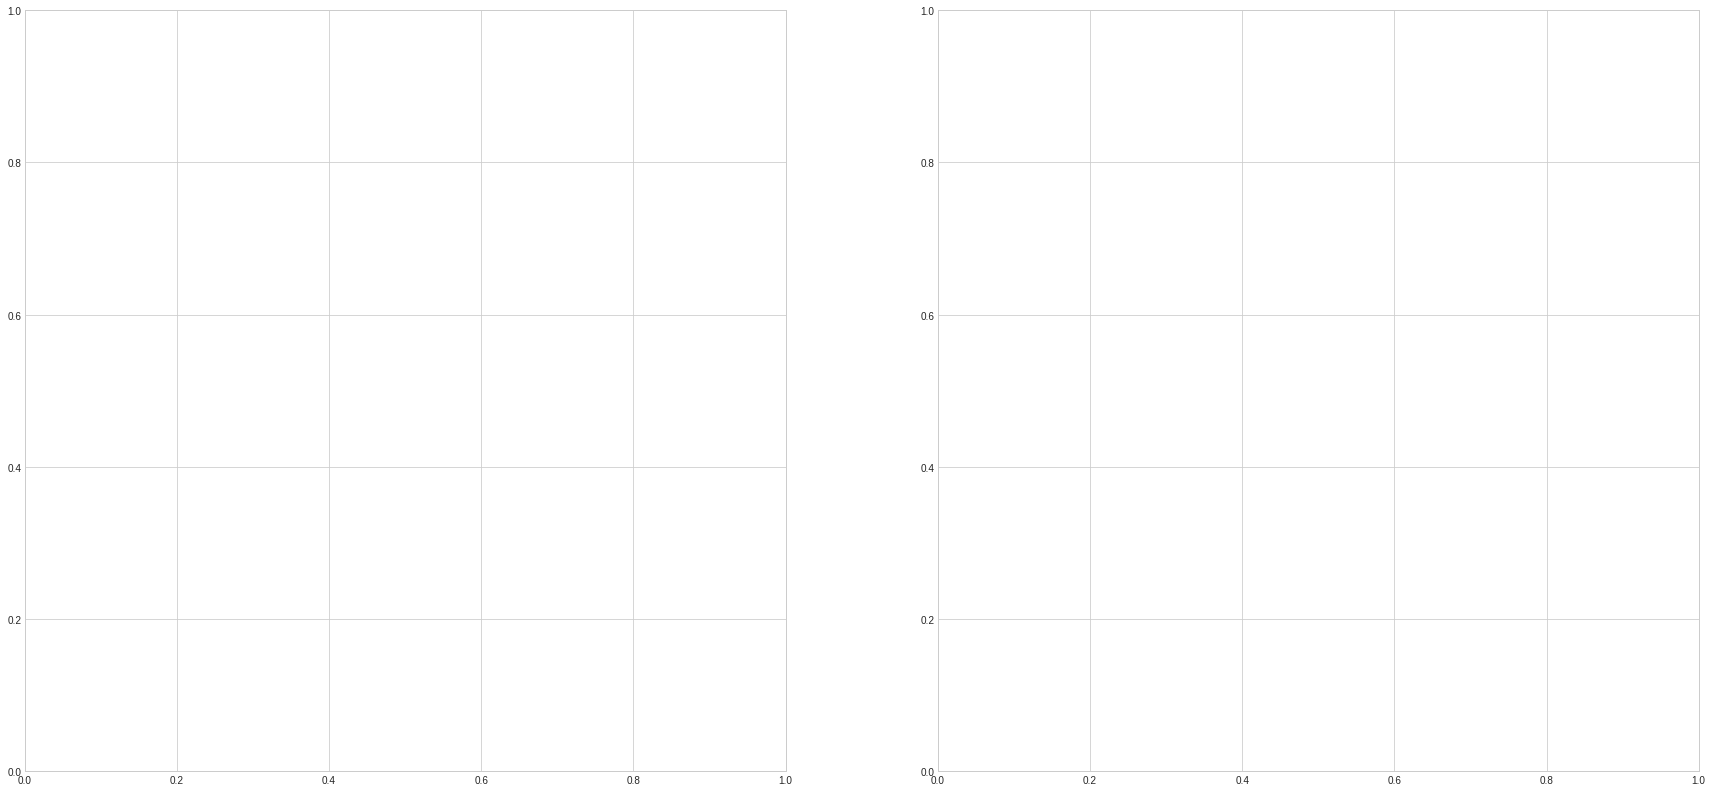

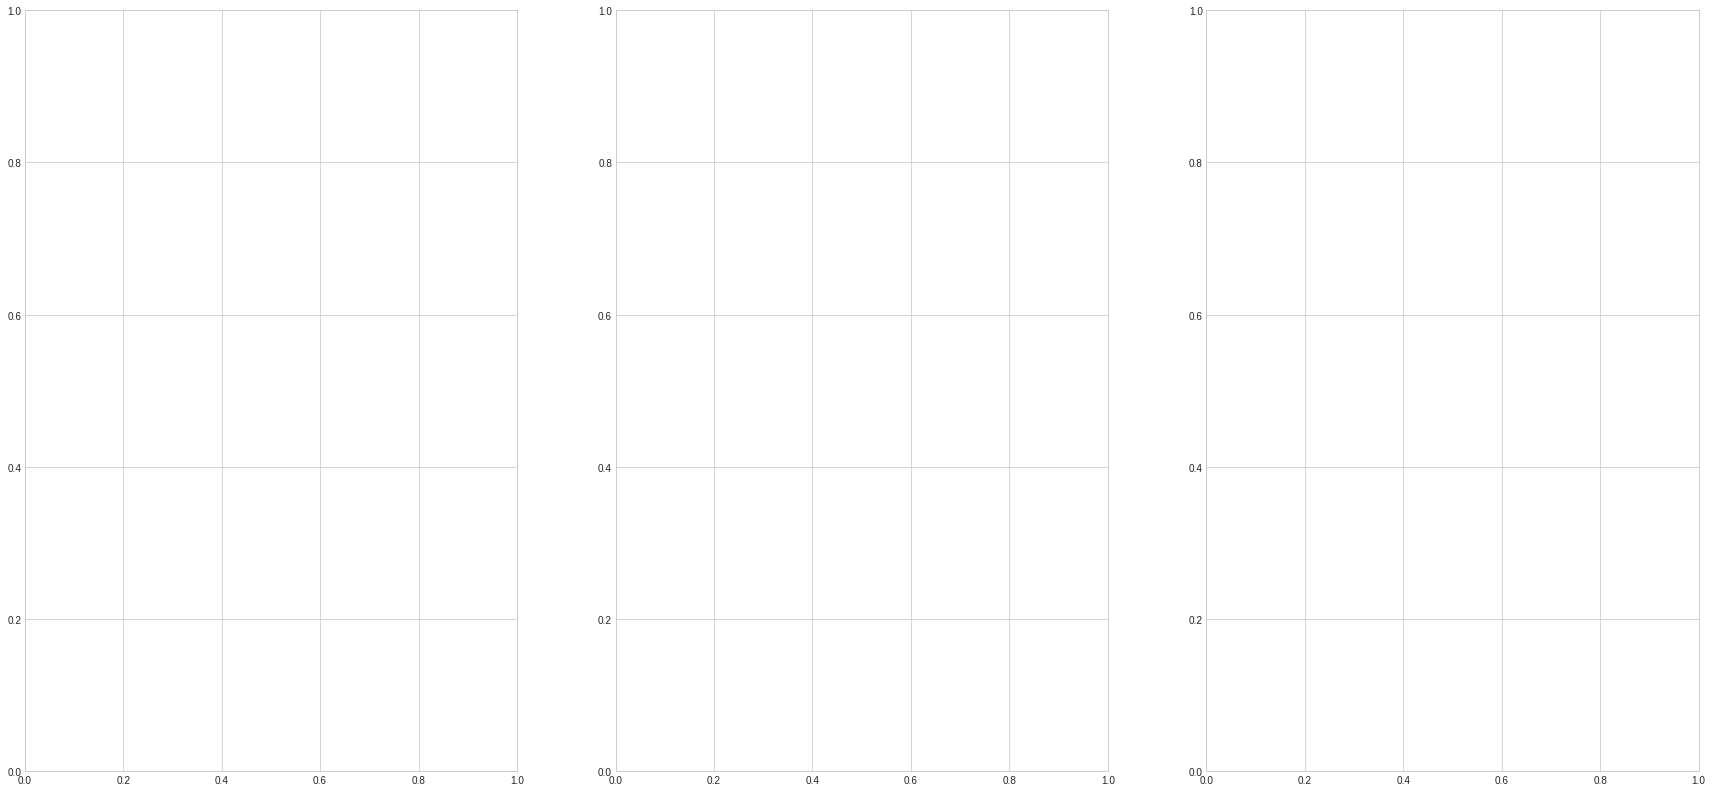

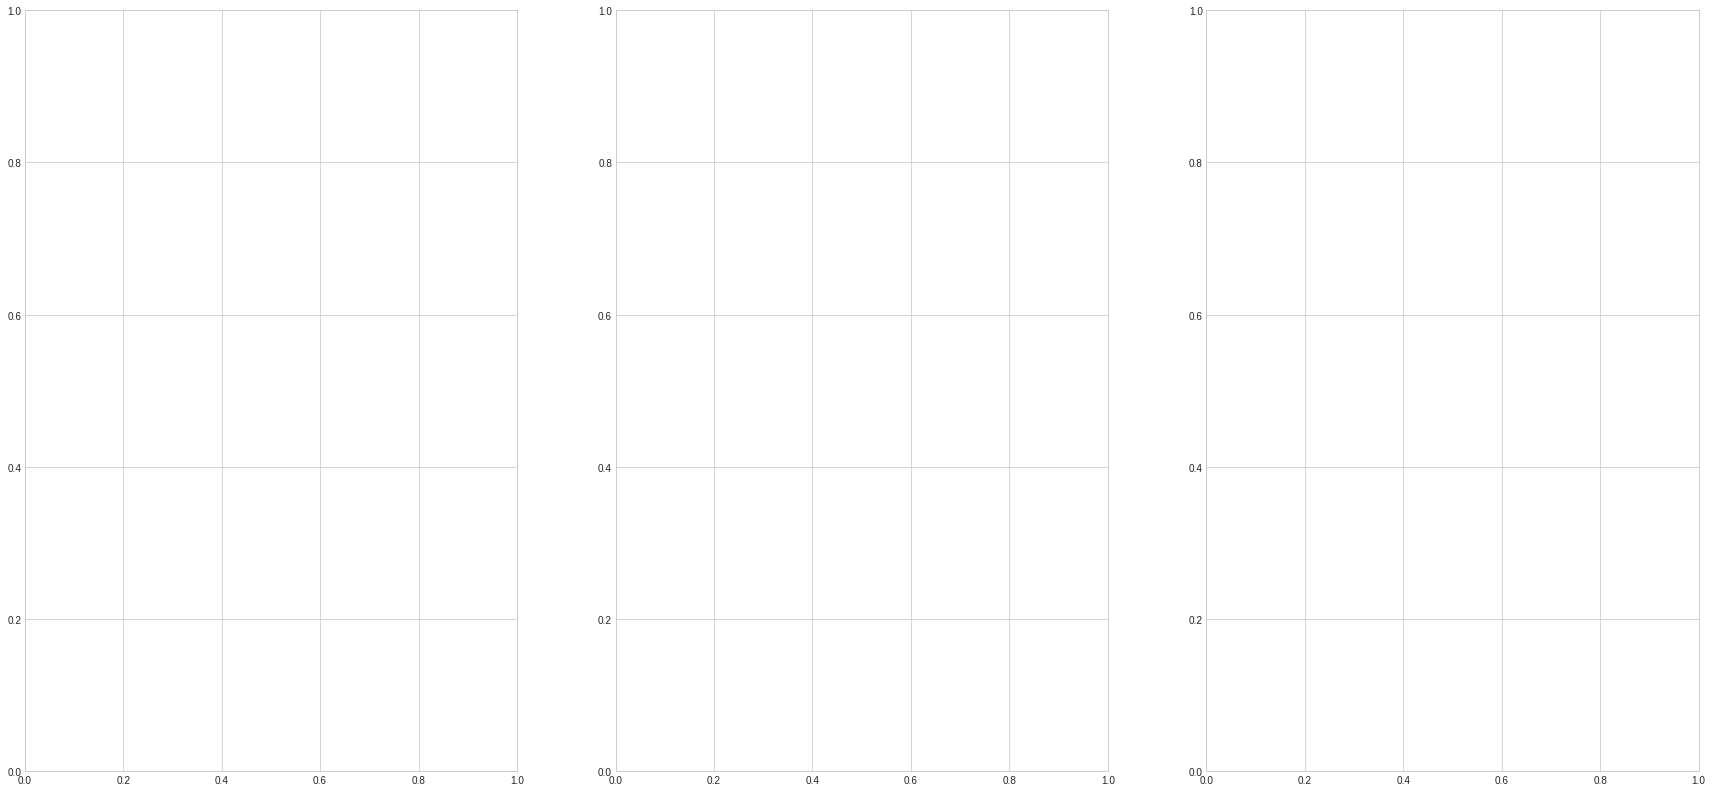

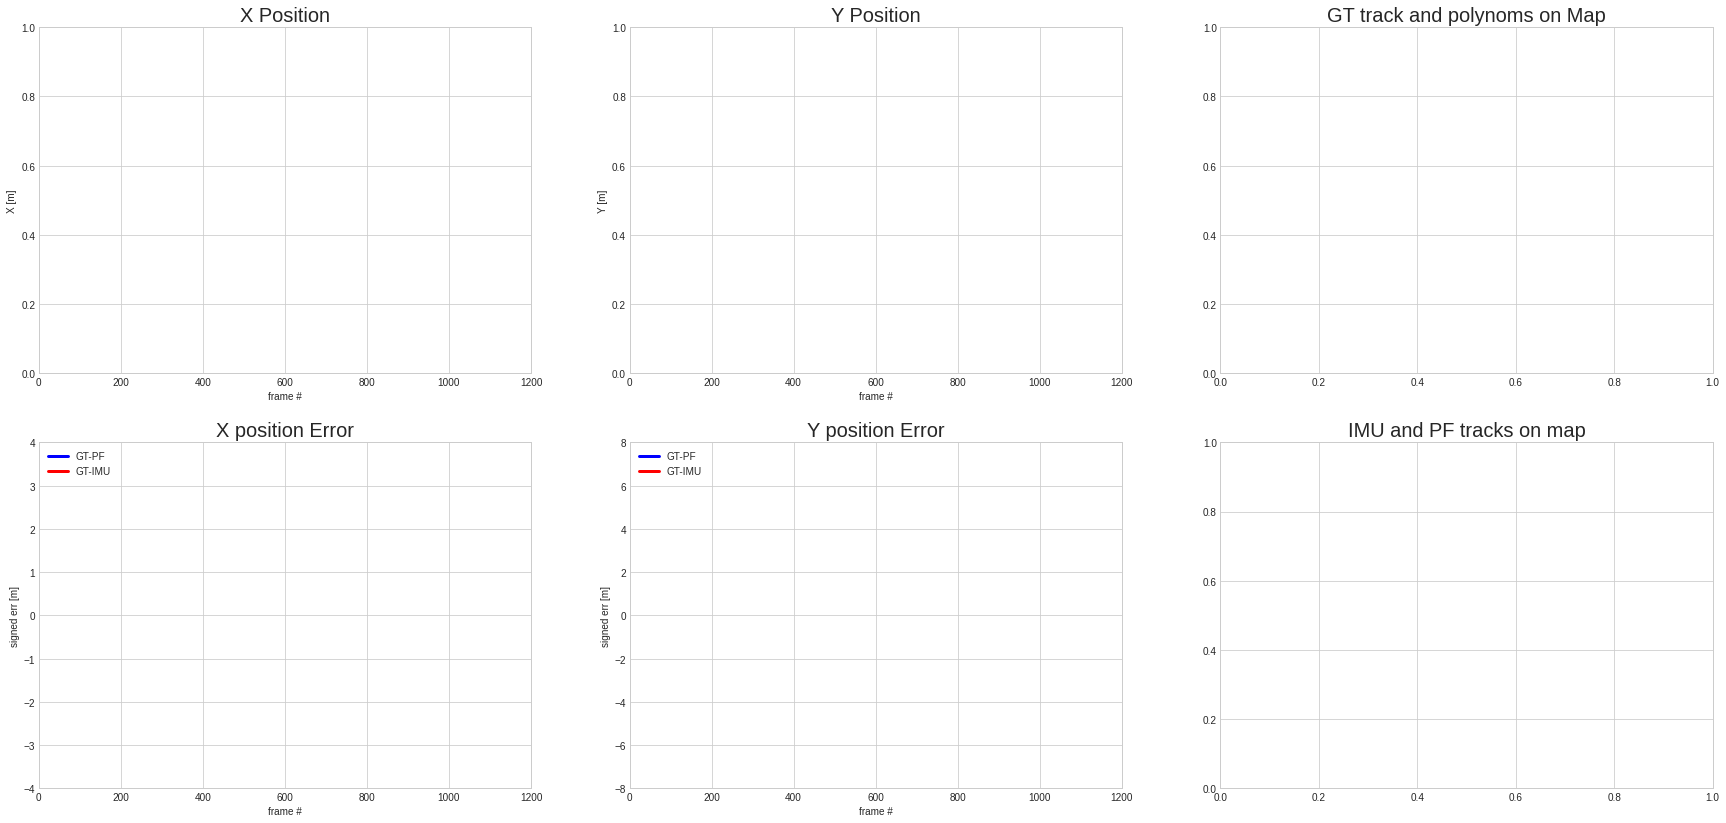

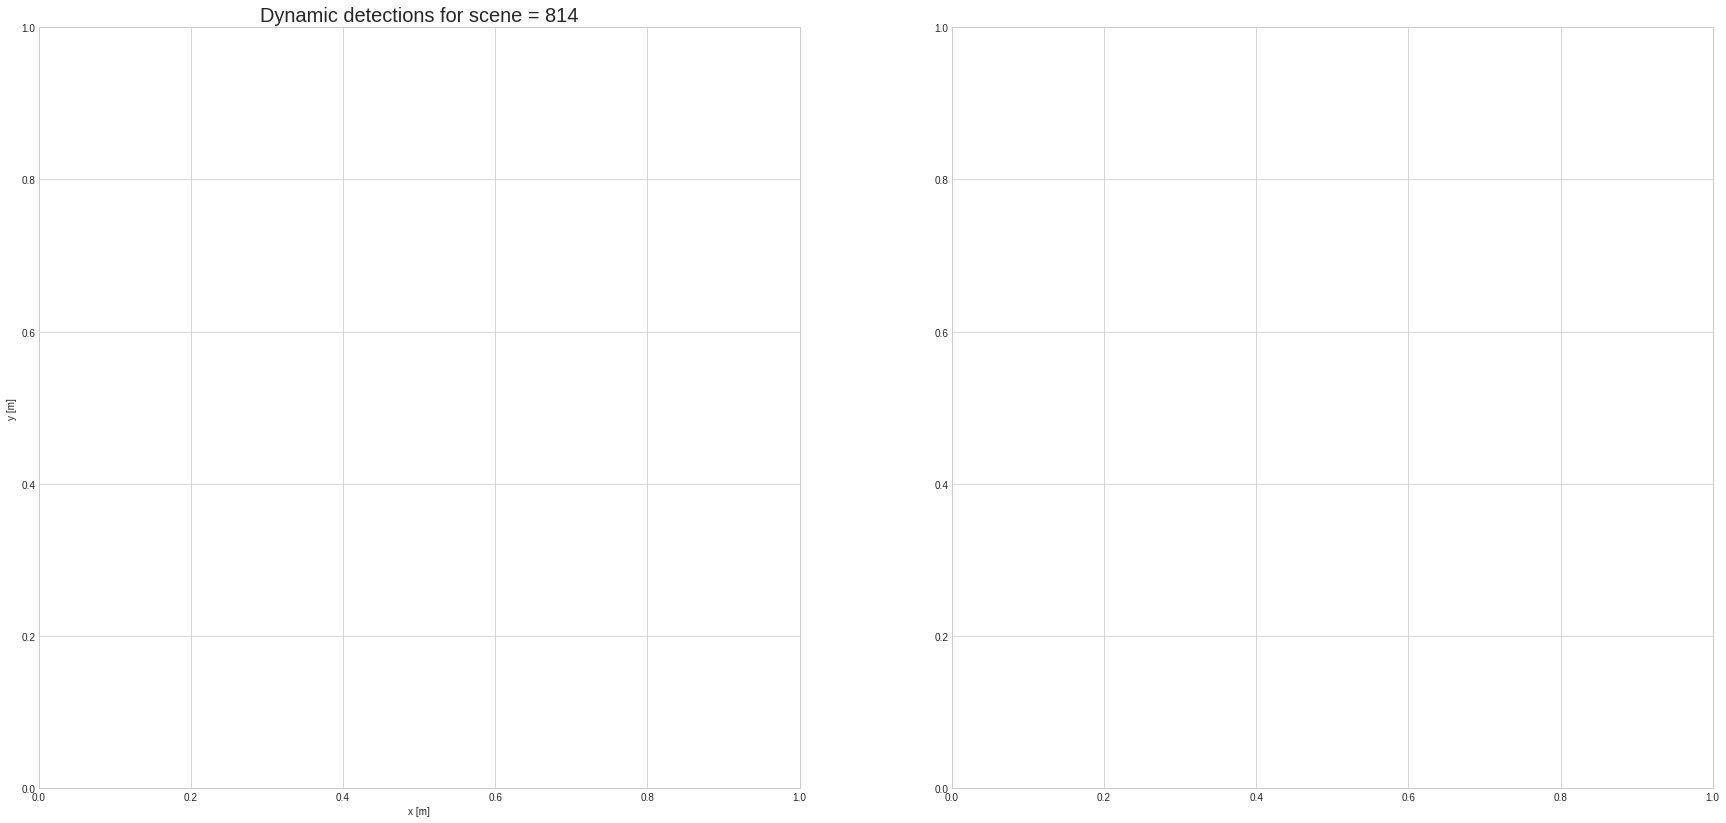

In [2]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 814
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

In [3]:
from tqdm import tqdm
import math
from metrics import *

In [7]:
from database import NuscenesProcessedDatabase
from tqdm import tqdm
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in tqdm(range(0,200)):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = False
    sim.video_list["video_debug"] = False
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = False
    sim.video_list["dynamic_tracker"] = False

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

self.dir_name images/814/database


  0%|          | 0/200 [00:00<?, ?it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


PF RMSE lateral: 0.011485451677993691
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0


No handles with labels found to put in legend.
  0%|          | 1/200 [00:01<04:07,  1.24s/it]

PF RMSE lateral: 0.04442978281560927
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04783997033288175
IMU RMSE longitudal: 0.0


  1%|          | 2/200 [00:02<03:46,  1.14s/it]

PF RMSE lateral: 0.040533018112826426
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.041299238350159986
IMU RMSE longitudal: 0.0


  2%|▏         | 3/200 [00:03<03:33,  1.08s/it]

PF RMSE lateral: 0.041794218597803544
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.044888767007759255
IMU RMSE longitudal: 0.0


  2%|▏         | 4/200 [00:04<03:25,  1.05s/it]

PF RMSE lateral: 0.04068367717475314
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.042918670726321724
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.3773171938338775, 2.076117806329708] cost_mean [1.46708752631336, 1.0757500963511253]


  2%|▎         | 5/200 [00:05<03:31,  1.09s/it]

PF RMSE lateral: 0.04783491876067411
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05100533206929821
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.387657691769874, 2.0183953765908087, 3.105836320173868] cost_mean [1.3582755182040929, 1.3575263029268332, 1.2209183991395485]


  3%|▎         | 6/200 [00:06<03:38,  1.13s/it]

PF RMSE lateral: 0.052243033552600814
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05761293688613588
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.363333705365351, 1.6874577963831108, 2.5097246208142043, 3.5384720982000673] cost_mean [1.1709998264642738, 1.0697356194338046, 1.6149807896337485, 4.9609942428058]


  4%|▎         | 7/200 [00:07<03:44,  1.16s/it]

PF RMSE lateral: 0.05351841987401182
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05954991795379846
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.2834929947526938, 1.4648540006065, 2.17694292367122, 3.930138050298735, 2.5083924243923694] cost_mean [1.3509584953240035, 1.0041991295842985, 1.1395890463528893, 5.4441092948025105, 2.2546775071402765]


  4%|▍         | 8/200 [00:08<03:50,  1.20s/it]

PF RMSE lateral: 0.06233787817246894
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06786847412001723
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.3641000913507773, 1.7875356955979875, 2.790969164148314, 4.160960901962932, 18.18973944627923] cost_mean [1.240834954167216, 1.4484258318228183, 1.2195097322168826, 5.749380107444173, 23.239885372642984]


  4%|▍         | 9/200 [00:10<03:54,  1.23s/it]

PF RMSE lateral: 0.06409797310407539
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07000256689453829
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1386498238849605, 1.5942586742016571, 2.3366257238619417, 3.382523246678127, 13.165495641628125] cost_mean [1.1097916008949, 1.2824371345612124, 0.9718661275171009, 4.528090741004838, 18.267286830434543]


  5%|▌         | 10/200 [00:11<04:00,  1.26s/it]

PF RMSE lateral: 0.07129667219917998
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07556730867377971
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.539958788967468, 1.9013475576916388, 2.9372097020622654, 3.9984868250897363, 16.431130511437246] cost_mean [1.4158717328343695, 1.4910661747907392, 1.2330642562433145, 5.2615764105109255, 18.47516634633067]


  6%|▌         | 11/200 [00:13<04:05,  1.30s/it]

PF RMSE lateral: 0.08196959814197319
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08486318840277148
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.184558227939095, 1.2995811432277746, 2.5190572954767894, 3.376609752580488, 15.213883416535456, 4.490006977556002] cost_mean [1.2094911397614099, 1.1344218276312659, 1.0394658571009923, 4.290481353469713, 18.74602159020456, 11.149456615187846]
n_tracks 1 cost_dyn_true [2.16810574578766] cost_dyn_mean [0.26228908070194745]
abs_vel =[13.73369737]
xlim [1020.0810632559214, 1026.2979836500083] ylim [2619.874251974766, 2629.4402207163153]
abs_vel =[13.73369737]


  6%|▌         | 12/200 [00:14<04:28,  1.43s/it]

PF RMSE lateral: 0.08491753101852817
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08793840642925144
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.2115869768259788, 1.6557532177508034, 1.5916479456445376, 3.714002122573793, 18.86180878237758, 6.79590603002028] cost_mean [1.2508543944860688, 1.0685704546398183, 1.4660919986156185, 4.7206018910309275, 17.68257846992788, 4.509540869400383]
n_tracks 1 cost_dyn_true [2.1806657592543823] cost_dyn_mean [0.31274369479168623]
abs_vel =[13.73492151]
xlim [1018.8620898548647, 1025.699955840084] ylim [2618.1501072129604, 2628.5220888061976]
abs_vel =[13.73492151]


  6%|▋         | 13/200 [00:16<04:48,  1.54s/it]

PF RMSE lateral: 0.09137726142821141
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.09268897733552278
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.3298048773309732, 1.754742338062496, 2.013281415357376, 4.080782216894872, 14.359590189015064, 6.210933687694348] cost_mean [1.412248372822756, 1.0084969804348067, 0.9287500696867342, 5.064905665015962, 15.725698798477284, 3.9781555351546234]
n_tracks 1 cost_dyn_true [2.372310344786498] cost_dyn_mean [0.3787790761623138]
abs_vel =[13.74214659]
xlim [1018.263796038128, 1025.2437574735895] ylim [2617.294653438367, 2627.8191872775337]
abs_vel =[13.74214659]


  7%|▋         | 14/200 [00:18<05:02,  1.63s/it]

PF RMSE lateral: 0.09456441343538098
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0953733551668054
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.1155054645591127, 1.5024676196546665, 2.243466269429503, 3.6658895931836875, 16.84212787700296, 5.075137379156241] cost_mean [1.2369217892606776, 1.1396583076721045, 1.0858898179697025, 4.206338630400868, 23.815163474185127, 5.607274294814778]
n_tracks 1 cost_dyn_true [2.626349054869297] cost_dyn_mean [0.5063334038718952]
abs_vel =[13.75178269]
xlim [1017.7270569483535, 1024.580327060951] ylim [2616.398680927099, 2626.7942150731715]
abs_vel =[13.75178269]


  8%|▊         | 15/200 [00:20<05:13,  1.69s/it]

PF RMSE lateral: 0.10135885514902819
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10103266884027479
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.228136975293645, 1.9063688120338589, 4.405780283276126, 20.802582014551763, 5.308585354501431] cost_mean [1.3041234296274586, 0.9235440888017147, 4.928245822405232, 21.86787705473852, 4.39533465183728]
n_tracks 1 cost_dyn_true [2.4099467636976164] cost_dyn_mean [0.6145416855685808]
abs_vel =[13.76276942]
xlim [1017.1176540107142, 1023.4456432524315] ylim [2615.5147216639043, 2625.0798407597003]
abs_vel =[13.76276942]


  8%|▊         | 16/200 [00:22<05:21,  1.74s/it]

PF RMSE lateral: 0.10397101660955037
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10373936329594802
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.0264405231247329, 3.3700076442016065, 17.558393698809194, 3.8014044486353353, 1.2750257894796238] cost_mean [1.1382621493578753, 3.760929562796971, 19.072853684923235, 4.118559822757667, 1.2739034950585775]
n_tracks 1 cost_dyn_true [2.2506703295382273] cost_dyn_mean [0.7319756253357415]
abs_vel =[13.77354982]
xlim [1016.5876499204924, 1022.9033660311235] ylim [2614.606404032567, 2624.1866400617105]
abs_vel =[13.77354982]


  8%|▊         | 17/200 [00:23<05:27,  1.79s/it]

PF RMSE lateral: 0.10660845039376042
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10688519416009977
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.190786766840492, 17.2600564843738, 7.28891030649697, 1.5935176245989733] cost_mean [1.4792016421436467, 17.554307731988565, 4.863481806203853, 1.1038554159307374]
n_tracks 1 cost_dyn_true [2.6186893247577796] cost_dyn_mean [0.7281488364816742]
abs_vel =[13.77822869]
xlim [1015.3459893124951, 1022.3467975066181] ylim [2612.8572746999735, 2623.3284588681477]
abs_vel =[13.77822869]


  9%|▉         | 18/200 [00:25<05:34,  1.84s/it]

PF RMSE lateral: 0.1117912308996382
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1120037816954809
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1798534792919688, 20.678540361853393, 7.052439943391476, 1.1176004791975758, 1.9872166303414764] cost_mean [1.3661855770772537, 20.553127166012384, 4.7743510615484865, 1.122289078142104, 2.3614802871950196]
n_tracks 1 cost_dyn_true [3.1466736732876424] cost_dyn_mean [0.8260473508807817]
abs_vel =[13.78062954]
xlim [1014.7367969151859, 1021.8583223879509] ylim [2611.9981216323927, 2622.6266301289984]
abs_vel =[13.78062954]


 10%|▉         | 19/200 [00:27<05:39,  1.87s/it]

PF RMSE lateral: 0.11373381891008641
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11465286549876616
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.1018674810172113, 15.268511561515655, 5.047752491562515, 1.2060549607580633, 2.321430069185284, 0.979274224048679] cost_mean [1.4504480700490006, 15.982825979872302, 5.4440437366278775, 1.3812259898440513, 2.1650781200813567, 2.4673459096963555]
n_tracks 1 cost_dyn_true [3.3423628843045394] cost_dyn_mean [0.8289249083473975]
abs_vel =[13.78225453]
xlim [1014.1225842748378, 1021.1675539780726] ylim [2611.1281375775648, 2621.621439832968]
abs_vel =[13.78225453]


 10%|█         | 20/200 [00:29<05:43,  1.91s/it]

PF RMSE lateral: 0.1159695384442104
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11769921247959857
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.7232231837361869, 15.293442271371198, 4.847182125811604, 1.3764032666805657, 2.2670438434517868, 0.829425269122396, 3.1606079559022096, 0.8586216125795598] cost_mean [1.0127358326545872, 16.227721288146192, 3.9275386686858504, 1.1514599246375528, 2.4334893385745175, 2.5227260717605637, 3.7135616977459858, 0.8073785882212912]
n_tracks 1 cost_dyn_true [3.4335894413929706] cost_dyn_mean [0.9124398770097706]
abs_vel =[13.78390308]
xlim [1013.5260936182032, 1020.5920504001407] ylim [2610.1977297834796, 2620.756942036067]
abs_vel =[13.78390308]


 10%|█         | 21/200 [00:31<05:46,  1.94s/it]

PF RMSE lateral: 0.11810379854906439
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12094728239298315
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.9989161429976349, 12.23677991665609, 3.751477599277923, 1.3272036280525275, 1.8692093459102765, 1.162120604925946, 4.643104739860636, 0.8270718374043766] cost_mean [1.3531153384256913, 13.183663101014295, 3.6887352056893556, 1.1140539010505048, 1.8555075155703176, 2.4394781146222493, 4.988034127970133, 0.8087572555939309]
n_tracks 1 cost_dyn_true [3.5868742793159436] cost_dyn_mean [0.9701177902707439]
abs_vel =[13.78591105]
xlim [1012.9366797327187, 1019.4217594446701] ylim [2609.3497142143674, 2619.0994567665616]
abs_vel =[13.78591105]


 11%|█         | 22/200 [00:33<05:47,  1.95s/it]

PF RMSE lateral: 0.11996478939751863
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12446656374936096
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.8009635357648919, 13.445708126677754, 2.5921362085677795, 1.3798802189991533, 1.8212710762363593, 0.8678488440076998, 3.702935582814234, 0.8298249963144897] cost_mean [1.0407265985774055, 13.936283158853426, 4.145162322898068, 1.1435231336259712, 2.0933280106019856, 2.6922205231134786, 4.184121646519389, 0.683127489205184]
n_tracks 1 cost_dyn_true [3.5950017348084446] cost_dyn_mean [0.9503368268488634]
abs_vel =[13.78815463]
xlim [1012.3479580091423, 1018.8092577242178] ylim [2608.47099305527, 2618.2247192863338]
abs_vel =[13.78815463]


 12%|█▏        | 23/200 [00:35<05:48,  1.97s/it]

PF RMSE lateral: 0.12333101871327744
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1288780804530463
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.9309488586549411, 22.006122538061053, 7.523508366719933, 1.4854334752089957, 2.1373476281331083, 0.9509958189092854, 4.284294390902243, 0.7730773410847613] cost_mean [1.365851541815295, 21.075249182219885, 5.463997704730187, 0.9239051401267612, 2.239708935016596, 2.539815616625713, 4.386152639441083, 0.6861927859308954]
n_tracks 1 cost_dyn_true [3.4498319475263965] cost_dyn_mean [0.9632349089181356]
abs_vel =[13.79238846]
xlim [1011.1071750852931, 1018.3074050057998] ylim [2606.674291904017, 2617.4118805337675]
abs_vel =[13.79238846]


 12%|█▏        | 24/200 [00:37<05:49,  1.99s/it]

PF RMSE lateral: 0.12880825931874826
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.13468091349992015
IMU RMSE longitudal: 0.0
n_polynoms 9 cost_true [0.8337260820101783, 14.35083737477819, 5.3920098122006355, 1.3257383847189035, 2.1376018509927808, 0.9340532270339711, 4.101695286159587, 0.8401159264627502, 2.8911983387359266] cost_mean [1.2527246006810178, 16.28510700728481, 4.352652883338801, 1.0488744449984126, 2.3634612721298973, 2.4745091228726674, 4.390365342663876, 0.7303193977515706, 2.378313288121178]
n_tracks 1 cost_dyn_true [3.5303898623687253] cost_dyn_mean [1.0061502916478076]
abs_vel =[13.79763075]
xlim [1010.5116755297191, 1017.6651604200545] ylim [2605.8173570777303, 2616.4802502090924]
abs_vel =[13.79763075]


 12%|█▎        | 25/200 [00:39<05:52,  2.01s/it]

PF RMSE lateral: 0.1329654526903562
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.13948278296949262
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [12.719153006425183, 4.265831940324689, 1.1256344495522765, 2.812692985949969, 1.0689771333917302, 3.1917555334987195, 0.7588405561739819, 2.630104901261899] cost_mean [15.361127104839879, 3.922259319200575, 1.2000477861868935, 2.9612801945971796, 2.473779084149782, 3.8058944600139712, 0.6432774028603542, 1.8533558358467255]
n_tracks 1 cost_dyn_true [3.49185756937523] cost_dyn_mean [1.0137685197812791]
abs_vel =[13.80229135]
xlim [1009.9036045455668, 1017.1679559383834] ylim [2604.963198405728, 2615.6140443279737]
abs_vel =[13.80229135]


 13%|█▎        | 26/200 [00:42<05:53,  2.03s/it]

PF RMSE lateral: 0.13635499828320688
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14368633855910004
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [4.849871887591333, 1.6506257723533222, 1.970573561051882, 0.9648803227510375, 4.598850322018088, 0.7072389772221935, 2.8862719445725102] cost_mean [3.6735079254212706, 1.0672970763507388, 2.1413379765330327, 2.583576025974488, 4.4060920469798095, 0.8724376179743881, 2.8825405482266078]
n_tracks 1 cost_dyn_true [3.5071081646308313] cost_dyn_mean [1.0307109552923892]
abs_vel =[13.80545897]
xlim [1009.3575826161823, 1015.8843323603855] ylim [2604.1427493985357, 2613.801817187257]
abs_vel =[13.80545897]


 14%|█▎        | 27/200 [00:44<05:55,  2.05s/it]

PF RMSE lateral: 0.1397592028904031
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14811503400654125
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.8530112138600145, 1.2210148368520541, 3.597711113833841, 0.8307294895541151, 2.967887511704786] cost_mean [1.8841096124362213, 2.8857968624068606, 3.55855472221561, 0.80243823329151, 2.28092606115229]
n_tracks 1 cost_dyn_true [3.656376323821765] cost_dyn_mean [1.0881039276581994]
abs_vel =[13.80823613]
xlim [1008.7955582959207, 1015.2663167847091] ylim [2603.2530939469493, 2612.932358243765]
abs_vel =[13.80823613]


 14%|█▍        | 28/200 [00:46<05:58,  2.08s/it]

PF RMSE lateral: 0.14355883920607385
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1533229692520851
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.4159151080253904, 0.9635159640918963, 4.310409140898956, 0.8753962251352492, 3.33482881390234, 1.1168878551054144] cost_mean [2.598516601124453, 2.468585997804372, 3.8979507975155037, 0.8914912733252286, 2.800991789037107, 1.189973674541572]
n_tracks 1 cost_dyn_true [3.5317809558183364] cost_dyn_mean [1.0634847908049871]
abs_vel =[13.81262189]
xlim [1007.5266915859394, 1014.7263252990056] ylim [2601.4549831640384, 2612.200836184458]
abs_vel =[13.81262189]


 14%|█▍        | 29/200 [00:48<06:00,  2.11s/it]

PF RMSE lateral: 0.1490139433593001
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1602379932959738
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [0.8704090162606497, 4.015459659871765, 0.7697409411797881, 2.859409852509281, 1.0294944312203826, 2.3125198145602384] cost_mean [2.573015019474245, 4.380878822979458, 0.747727612762306, 2.122282255263706, 1.246326961852931, 0.8692457938752887]
n_tracks 1 cost_dyn_true [3.551122458472683] cost_dyn_mean [1.0904365931876614]
abs_vel =[13.81791364]
xlim [1006.9201861145101, 1014.1392564846271] ylim [2600.567166932865, 2611.3010937772283]
abs_vel =[13.81791364]


 15%|█▌        | 30/200 [00:50<06:02,  2.13s/it]

PF RMSE lateral: 0.1532024803636758
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.16595499118225054
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [4.690011220865657, 0.7603808967880936, 2.7639254910138296, 1.1442209296869308, 1.8354845753739701] cost_mean [4.446975918272377, 0.6981327695468083, 2.1184916719792044, 1.0072195458637083, 0.7052901945507687]
n_tracks 1 cost_dyn_true [3.5014521066450284] cost_dyn_mean [1.084850540500627]
abs_vel =[13.82174194]
xlim [1006.3116768091215, 1013.5129233805193] ylim [2599.7104881563046, 2610.4005501254787]
abs_vel =[13.82174194]


 16%|█▌        | 31/200 [00:52<06:04,  2.16s/it]

PF RMSE lateral: 0.1579635668427483
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1728614812296988
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.366150770403107, 1.2397342472972654, 1.8508725386076945, 1.087533210907221] cost_mean [1.8123877977222789, 1.1545664142832421, 0.8197716188114569, 3.042386334530734]
n_tracks 1 cost_dyn_true [3.460702703163399] cost_dyn_mean [1.0369528712114398]
abs_vel =[13.825706]
xlim [1005.676194322226, 1012.9360676529884] ylim [2598.8058552522257, 2609.543209068576]
abs_vel =[13.825706]


 16%|█▌        | 32/200 [00:55<06:07,  2.18s/it]

PF RMSE lateral: 0.16164700559297437
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1790212645335932
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [3.1133828958727054, 1.205457264201143, 1.7835328788572786, 0.8476773182781978] cost_mean [2.702417143580087, 0.8787763507412765, 0.8067034879599716, 2.4912495881935897]
n_tracks 1 cost_dyn_true [3.563480667009613] cost_dyn_mean [1.0608433019533365]
abs_vel =[13.82971201]
xlim [1005.1419050700893, 1011.6830550863112] ylim [2597.973161462527, 2607.712740765017]
abs_vel =[13.82971201]


 16%|█▋        | 33/200 [00:57<06:08,  2.21s/it]

PF RMSE lateral: 0.165292624580426
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.18517426847758753
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.7235438669955565, 1.1529845410986785, 2.04480888087739, 1.2085359591273177] cost_mean [2.160737629374666, 1.3119225903273917, 0.80837078601471, 2.3789533044995395]
n_tracks 1 cost_dyn_true [3.811828284148075] cost_dyn_mean [1.1684322638562317]
abs_vel =[13.83413001]
xlim [1004.5591670544263, 1011.0493127286425] ylim [2596.9845845131304, 2606.8062736016423]
abs_vel =[13.83413001]


 17%|█▋        | 34/200 [00:59<06:11,  2.24s/it]

PF RMSE lateral: 0.16917702217493347
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19178003182326753
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [3.184573028653687, 1.153048905387326, 1.6885234044775823, 0.9038482522843437] cost_mean [2.8277813385902677, 1.0398900238773467, 0.8474228943509339, 2.415325082880609]
n_tracks 1 cost_dyn_true [3.745370348624176] cost_dyn_mean [1.2635318194962168]
abs_vel =[13.83723442]
xlim [1003.3141561992853, 1010.4783252286709] ylim [2595.2154514516556, 2606.0268603924674]
abs_vel =[13.83723442]


 18%|█▊        | 35/200 [01:02<06:16,  2.28s/it]

PF RMSE lateral: 0.17321311817504567
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19864710481174766
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.125896527780534, 2.006155719954768, 0.9258214541367629] cost_mean [1.1558021946622183, 0.8901710097730358, 2.4684031854095982]
n_tracks 1 cost_dyn_true [3.812945099548174] cost_dyn_mean [1.2722057159279467]
abs_vel =[13.84055775]
xlim [1002.755162752552, 1009.9464736707295] ylim [2594.3972237872877, 2605.2302515419788]
abs_vel =[13.84055775]


 18%|█▊        | 36/200 [01:04<06:26,  2.36s/it]

PF RMSE lateral: 0.17720111768693472
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2055564439011234
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.1351614726750694, 1.4869616149289842, 0.9456604690258041, 2.367683666820124] cost_mean [0.9699402582860437, 0.7261638792541302, 2.50892424440813, 2.2113530772592696]
n_tracks 1 cost_dyn_true [3.8302155437936394] cost_dyn_mean [1.271792079501036]
abs_vel =[13.84460335]
xlim [1002.1215695017972, 1009.3691341888423] ylim [2593.4724264079146, 2604.3234950579417]
abs_vel =[13.84460335]


 18%|█▊        | 37/200 [01:07<06:59,  2.57s/it]

PF RMSE lateral: 0.17946740663301045
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21117445971233284
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0514973547742883, 2.1372651146160644, 1.0963133634794744, 2.0955977317639047] cost_mean [0.9849458248701216, 0.28848507617326224, 2.3880626006477477, 1.6639860246874325]
n_tracks 1 cost_dyn_true [4.016744171274695] cost_dyn_mean [1.2771838011298131]
abs_vel =[13.84947803]
xlim [1001.5833056801781, 1008.0651240891265] ylim [2592.619814156705, 2602.452078776274]
abs_vel =[13.84947803]


 19%|█▉        | 38/200 [01:10<07:22,  2.73s/it]

PF RMSE lateral: 0.18314314893950728
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21808918259809235
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9247148806134351, 1.4539192454679108, 0.9081802667475339, 3.012545800285995] cost_mean [0.887218010775023, 0.8169701470870805, 2.3786735307997064, 2.4596194580479436]
n_tracks 1 cost_dyn_true [4.001675062852861] cost_dyn_mean [1.308426197911178]
abs_vel =[13.85540588]
xlim [1000.9642601158455, 1007.4740130963103] ylim [2591.7316318023004, 2601.579933634973]
abs_vel =[13.85540588]


 20%|█▉        | 39/200 [01:13<07:37,  2.84s/it]

PF RMSE lateral: 0.18865174081084932
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22689254388609498
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.4539740772084453, 1.0694264265853903, 2.2528177281450947] cost_mean [0.8426159311074474, 2.506408581860267, 2.007264737072843]
n_tracks 1 cost_dyn_true [3.8691425985772208] cost_dyn_mean [1.3120945372098882]
abs_vel =[13.860201]
xlim [999.7510976096752, 1006.9694156956135] ylim [2589.9669498569906, 2600.889477325553]
abs_vel =[13.860201]


 20%|██        | 40/200 [01:17<07:50,  2.94s/it]

PF RMSE lateral: 0.19045659089103592
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23288534677315656
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.2153058407276853, 2.455548642939005] cost_mean [2.391095535712606, 2.2407852165903837]
n_tracks 1 cost_dyn_true [3.8967445402079512] cost_dyn_mean [1.3058325445740908]
abs_vel =[13.86477096]
xlim [999.1024076903745, 1006.1977681650219] ylim [2589.033661087278, 2599.785963944803]
abs_vel =[13.86477096]


 20%|██        | 41/200 [01:19<07:41,  2.90s/it]

PF RMSE lateral: 0.1923004710872422
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23913258142231808
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.4679145736080805, 1.7412373111698005] cost_mean [2.4747176715783756, 1.4836325164221682]
n_tracks 1 cost_dyn_true [3.8682622276532674] cost_dyn_mean [1.2598193264682547]
abs_vel =[13.86948701]
xlim [998.4779426868802, 1005.6875672479499] ylim [2588.137885896705, 2598.9772610015007]
abs_vel =[13.86948701]


 21%|██        | 42/200 [01:22<07:25,  2.82s/it]

PF RMSE lateral: 0.19507293329638417
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24653759957002322
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.5061211855643872, 1.1374978475952704] cost_mean [2.0453819535272117, 1.0055020996339217]
n_tracks 1 cost_dyn_true [3.866997771176506] cost_dyn_mean [1.1938430573924161]
abs_vel =[13.87449341]
xlim [997.8747807880287, 1005.1440942713346] ylim [2587.2478885930573, 2598.0541194208445]
abs_vel =[13.87449341]


 22%|██▏       | 43/200 [01:25<07:15,  2.77s/it]

PF RMSE lateral: 0.1965609086458483
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2529725468501443
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.0659025347461686, 1.192182392369738, 2.6494302339932085] cost_mean [1.7731891482931876, 0.965348335458593, 2.4455778707933513]
n_tracks 1 cost_dyn_true [3.9091049426091042] cost_dyn_mean [1.162479340446152]
abs_vel =[13.87982188]
xlim [997.3064238114799, 1003.8849488543768] ylim [2586.3949898332307, 2596.241173099707]
abs_vel =[13.87982188]


 22%|██▏       | 44/200 [01:27<07:09,  2.75s/it]

PF RMSE lateral: 0.19906521006932362
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2604102587690686
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.4162233087731686, 0.7970138491268745, 2.6211327297354385] cost_mean [1.3222042243462688, 0.8491175718915132, 1.9613312984600952]
n_tracks 1 cost_dyn_true [3.9372672915408353] cost_dyn_mean [1.2043885816773212]
abs_vel =[13.88549866]
xlim [996.6940462656718, 1003.3454245255293] ylim [2585.4884200080924, 2595.4616108019422]
abs_vel =[13.88549866]


 22%|██▎       | 45/200 [01:30<07:02,  2.73s/it]

PF RMSE lateral: 0.20137570978034042
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.26802474540436433
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.8616203751447582, 0.8485948095802541, 2.441651800087954, 2.644091098045991] cost_mean [1.7862910537780263, 0.7734288558672062, 2.4151291156860832, 1.2445072067316314]
n_tracks 1 cost_dyn_true [3.8087887906141087] cost_dyn_mean [1.2195478692091215]
abs_vel =[13.89231873]
xlim [995.4437905481988, 1002.7105283695305] ylim [2583.6627766180027, 2594.5642425565597]
abs_vel =[13.89231873]


 23%|██▎       | 46/200 [01:33<07:01,  2.74s/it]

PF RMSE lateral: 0.20291797301639708
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.274685795677382
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6866336298739149, 0.9397641012908761, 2.5397058838602518, 2.4568988578832713, 1.026830524214253] cost_mean [1.6777447654425384, 0.8032112040445675, 2.5582401296515753, 1.433016119699887, 1.4958308785578291]
n_tracks 1 cost_dyn_true [4.011628008927855] cost_dyn_mean [1.2287281948850808]
abs_vel =[13.89979373]
xlim [994.8036545609796, 1002.1534163432925] ylim [2582.7196741659723, 2593.687511340524]
abs_vel =[13.89979373]


 24%|██▎       | 47/200 [01:36<06:57,  2.73s/it]

PF RMSE lateral: 0.2048984735847771
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28207996117377393
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8749572899112075, 2.675691582811354, 2.4533628146912188, 1.2898625644507213] cost_mean [0.9676320915203052, 2.160915557176139, 1.2248849538370872, 1.4843821332908178]
n_tracks 1 cost_dyn_true [3.997193184346671] cost_dyn_mean [1.208364317650192]
abs_vel =[13.90709396]
xlim [994.1968374733049, 1001.5299126242526] ylim [2581.8305766079425, 2592.7814125394593]
abs_vel =[13.90709396]


 24%|██▍       | 48/200 [01:38<07:00,  2.77s/it]

PF RMSE lateral: 0.20566326908925514
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28870504312504297
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0796230157638695, 2.631287622951807, 2.056810076663334, 1.2903216730325355] cost_mean [1.0123823841283033, 1.5685601966624025, 1.1266240552437357, 1.5557058132570458]
n_tracks 1 cost_dyn_true [3.862697391002786] cost_dyn_mean [1.1978374623917691]
abs_vel =[13.91412377]
xlim [993.6108279764144, 1000.217053725124] ylim [2581.000474547081, 2590.8748572638992]
abs_vel =[13.91412377]


 24%|██▍       | 49/200 [01:41<06:58,  2.77s/it]

PF RMSE lateral: 0.2071258593715645
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.29588595184054767
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9855695473790603, 2.585091735389433, 2.39927607745453, 1.196015576570688] cost_mean [0.817527988746231, 2.4378366578376984, 1.0567516150463818, 1.8500584331704495]
n_tracks 1 cost_dyn_true [3.7797538709688716] cost_dyn_mean [1.1708182737626482]
abs_vel =[13.92087955]
xlim [992.9691905393332, 999.6985812812914] ylim [2580.1155834243627, 2590.1309752494262]
abs_vel =[13.92087955]


 25%|██▌       | 50/200 [01:44<06:57,  2.79s/it]

PF RMSE lateral: 0.20795317872182642
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.30269121983876485
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9603253913731913, 2.571710160727633, 2.4217131113692667, 1.3798946323890366] cost_mean [1.1994886911213274, 1.9951020968970974, 1.016627340310402, 1.6062082892945446]
n_tracks 1 cost_dyn_true [3.6681412023426043] cost_dyn_mean [1.1135561130600138]
abs_vel =[13.92754059]
xlim [992.3338540123156, 999.0257025048115] ylim [2579.2469935379468, 2589.1693011317834]
abs_vel =[13.92754059]


 26%|██▌       | 51/200 [01:47<06:58,  2.81s/it]

PF RMSE lateral: 0.2086357848085721
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3097568725354483
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8167312754155168, 3.0719230539342957, 2.5375536623021233, 1.0896505007337944] cost_mean [0.9249726084594087, 1.8903564338613728, 1.222219600626535, 1.736205033589382]
n_tracks 1 cost_dyn_true [3.4092304157279667] cost_dyn_mean [1.0741580795157943]
abs_vel =[13.93443489]
xlim [991.0580239341476, 998.389783329718] ylim [2577.4192889045084, 2588.2435339866943]
abs_vel =[13.93443489]


 26%|██▌       | 52/200 [01:50<06:59,  2.83s/it]

PF RMSE lateral: 0.2097451868022011
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.31726234850180157
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9371817635458777, 2.391527031215894, 2.359534074022128, 1.1716588723639698] cost_mean [0.7603702271460864, 1.4830381714827208, 1.2670614145208745, 1.4665164604985672]
n_tracks 1 cost_dyn_true [3.448605090962853] cost_dyn_mean [1.037427932839039]
abs_vel =[13.94136726]
xlim [990.4093643436091, 997.8537451581394] ylim [2576.509407629644, 2587.4442238956017]
abs_vel =[13.94136726]


 26%|██▋       | 53/200 [01:53<07:03,  2.88s/it]

PF RMSE lateral: 0.21025677825719405
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.324133411283853
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.548006483646471, 2.3299302421099397, 1.1549619542746605] cost_mean [2.3502467887611, 1.253813658095799, 1.7169208518997223]
n_tracks 1 cost_dyn_true [3.452083869043948] cost_dyn_mean [1.002479176793846]
abs_vel =[13.94839412]
xlim [989.7474681710966, 997.170402811733] ylim [2575.5762078691946, 2586.4272929549825]
abs_vel =[13.94839412]


 27%|██▋       | 54/200 [01:56<06:59,  2.88s/it]

PF RMSE lateral: 0.2114905575034498
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3317774138754097
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.9665082642503457, 1.1227315244981662] cost_mean [1.1101296660876088, 1.723884477826555]
n_tracks 1 cost_dyn_true [3.2761485605587657] cost_dyn_mean [0.9601722724748462]
abs_vel =[13.95503221]
xlim [989.1113370028133, 995.975559206046] ylim [2574.7593182449536, 2584.6688293402663]
abs_vel =[13.95503221]


 28%|██▊       | 55/200 [01:59<06:58,  2.89s/it]

PF RMSE lateral: 0.21261471417742098
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3392605115242491
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.2309901825201677, 1.2296310826411678] cost_mean [1.1274078924748723, 1.7455297804125014]
n_tracks 1 cost_dyn_true [3.0667817877742656] cost_dyn_mean [0.940164568395019]
abs_vel =[13.96138731]
xlim [988.4069948982932, 995.3684347096233] ylim [2573.821636320265, 2583.77335891308]
abs_vel =[13.96138731]


 28%|██▊       | 56/200 [02:01<06:56,  2.89s/it]

PF RMSE lateral: 0.21398271569438782
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3469920399406919
IMU RMSE longitudal: 0.0
n_polynoms 1 cost_true [1.0132899369863486] cost_mean [1.619293769041782]
n_tracks 1 cost_dyn_true [2.8521086800504882] cost_dyn_mean [0.8867294296290307]
abs_vel =[13.96722365]
xlim [987.1128476220083, 994.7442613474725] ylim [2572.0151727341126, 2582.8766011161665]
abs_vel =[13.96722365]


 28%|██▊       | 57/200 [02:04<07:00,  2.94s/it]

PF RMSE lateral: 0.21457957867478059
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.35426856773336046
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.721138842834062, 0.9447850718423385] cost_mean [1.7920169549831524, 0.7708040268550141]
n_tracks 1 cost_dyn_true [2.9031390477568246] cost_dyn_mean [0.8457946005868004]
abs_vel =[13.97268899]
xlim [986.4686897847764, 994.145843745101] ylim [2571.136786853545, 2582.0137886629423]
abs_vel =[13.97268899]


 29%|██▉       | 58/200 [02:07<06:59,  2.95s/it]

PF RMSE lateral: 0.2154685538316001
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3619345189414231
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.5929690244321852, 0.8155323294143014, 1.132046437103686] cost_mean [1.5355199307478058, 0.7385882885439154, 1.952686291616246]
n_tracks 1 cost_dyn_true [2.8680466693692432] cost_dyn_mean [0.8068843759497464]
abs_vel =[13.97777766]
xlim [985.861882577657, 993.4974516214216] ylim [2570.2408142621907, 2581.129424101102]
abs_vel =[13.97777766]


 30%|██▉       | 59/200 [02:10<06:59,  2.97s/it]

PF RMSE lateral: 0.2157932066839768
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.36910945366160824
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.6630168686485076, 0.859763935950675, 1.03327666255891] cost_mean [1.5895792605010104, 0.8428627711965315, 1.742788475265036]
n_tracks 1 cost_dyn_true [2.7685188383234403] cost_dyn_mean [0.7628015447625311]
abs_vel =[13.98271134]
xlim [985.1867578862467, 992.8161815798591] ylim [2569.33221880477, 2580.192020368357]
abs_vel =[13.98271134]


 30%|███       | 60/200 [02:14<07:01,  3.01s/it]

PF RMSE lateral: 0.2159900969028643
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.37618824923169264
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.5658766698615696, 0.7858726902170993, 1.0662463021675839] cost_mean [1.8167875325669356, 0.8235719215467241, 1.7681265726146325]
n_tracks 1 cost_dyn_true [2.780842151751063] cost_dyn_mean [0.7291044631202771]
abs_vel =[13.98756961]
xlim [984.5714709964233, 991.6034965858641] ylim [2568.430125409895, 2578.4181567262754]
abs_vel =[13.98756961]


 30%|███       | 61/200 [02:17<07:02,  3.04s/it]

PF RMSE lateral: 0.21616983186815106
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.382921274312901
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.481731606905373, 0.7776102144058398, 1.071982178831901, 0.8952908536587597] cost_mean [1.5857509536949987, 0.8666255108225394, 1.441358317988692, 0.8560498343366423]
n_tracks 1 cost_dyn_true [2.8126754237976686] cost_dyn_mean [0.719557049921175]
abs_vel =[13.9922532]
xlim [983.941807193347, 990.8853256311485] ylim [2567.501292926864, 2577.3968665119214]
abs_vel =[13.9922532]


 31%|███       | 62/200 [02:20<07:03,  3.07s/it]

PF RMSE lateral: 0.21677995948468243
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3902312040657457
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.629530906102468, 0.8527736807016987, 1.1587600029747946, 0.8064093761465961] cost_mean [1.637998389415523, 0.8113529677390535, 1.8263848249461352, 0.7189401982725501]
n_tracks 1 cost_dyn_true [2.6632135095796245] cost_dyn_mean [0.6861209155106267]
abs_vel =[13.99656457]
xlim [982.687709516031, 990.2714913503694] ylim [2565.6714049125167, 2576.5742716190357]
abs_vel =[13.99656457]


 32%|███▏      | 63/200 [02:23<07:03,  3.09s/it]

PF RMSE lateral: 0.21766491277465616
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3977166598659051
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.5992574933539574, 0.867491685449194, 1.2805547883001798, 0.8821160641866962, 1.3300347663199679] cost_mean [1.6741435325712495, 0.7927373068796989, 1.7146528672147414, 0.8600575356380586, 2.3189982460558385]
n_tracks 1 cost_dyn_true [2.8527318259970196] cost_dyn_mean [0.7219345551757455]
abs_vel =[14.00076059]
xlim [982.0793710043137, 989.6308186099644] ylim [2564.765498371437, 2575.733284131396]
abs_vel =[14.00076059]


 32%|███▏      | 64/200 [02:26<07:05,  3.13s/it]

PF RMSE lateral: 0.21837176546123924
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4050224757178933
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.2698195269051786, 0.8344464498979477, 1.3378342720515506, 0.8171318995911665, 1.5255458373560564] cost_mean [1.5495603974068919, 0.7852492714675843, 1.5421689893728365, 0.7445426382919551, 1.7107227631340418]
n_tracks 1 cost_dyn_true [2.905238678751048] cost_dyn_mean [0.712905907764501]
abs_vel =[14.00492125]
xlim [981.4708058407527, 988.9094825772083] ylim [2563.8970455996814, 2574.770368278145]
abs_vel =[14.00492125]


 32%|███▎      | 65/200 [02:29<07:05,  3.15s/it]

PF RMSE lateral: 0.2199086924537816
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4129893700688405
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.3295248975880227, 0.8372662859513202, 1.7127098173843547, 1.0131789245051457, 1.243926795916286] cost_mean [1.3414399262267005, 0.819789537764171, 1.8309825692454653, 0.744224333807977, 1.6880902399323936]
n_tracks 1 cost_dyn_true [2.802203228303288] cost_dyn_mean [0.6830042111803739]
abs_vel =[14.00913493]
xlim [980.8934930919593, 987.6656820601966] ylim [2563.0477493876074, 2573.039288965186]
abs_vel =[14.00913493]


 33%|███▎      | 66/200 [02:33<07:04,  3.17s/it]

PF RMSE lateral: 0.22080631581473575
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4205668404469817
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.5549637737280597, 0.7922281394588347, 1.3287919752908348, 0.8370558449720298, 1.772885445867266] cost_mean [1.357220710721456, 0.741906468378297, 1.9843444027834747, 0.8647416419345942, 2.2384162648282984]
n_tracks 1 cost_dyn_true [2.7380350256866945] cost_dyn_mean [0.6711852140368548]
abs_vel =[14.01345231]
xlim [980.2649654335339, 987.009790326729] ylim [2562.147700560171, 2572.145540551117]
abs_vel =[14.01345231]


 34%|███▎      | 67/200 [02:36<07:05,  3.20s/it]

PF RMSE lateral: 0.2216135253508012
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4278373802215395
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.421121435071028, 0.7335929257724977, 1.4331508266511612, 0.9046230924365766, 1.9526703558440015] cost_mean [1.5202877583485137, 0.7022503805180056, 2.090330446139508, 0.9249151773905423, 1.7583654696725806]
n_tracks 1 cost_dyn_true [2.7203153264631323] cost_dyn_mean [0.6734784579921249]
abs_vel =[14.01780965]
xlim [979.6540516329002, 986.3464740007394] ylim [2561.2478676664387, 2571.152876558508]
abs_vel =[14.01780965]


 34%|███▍      | 68/200 [02:39<07:05,  3.22s/it]

PF RMSE lateral: 0.22314089020908237
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.43566305596293164
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.3430498975852714, 0.8585527353021665, 1.6218834136678644, 0.7780328951404151] cost_mean [1.7329544076779808, 0.967963994264949, 2.3770498424003965, 0.8514104541863226]
n_tracks 1 cost_dyn_true [2.6428258765846016] cost_dyn_mean [0.6557413386481377]
abs_vel =[14.02238039]
xlim [978.3710290119809, 985.8495510766892] ylim [2559.3947292684047, 2570.5101011317884]
abs_vel =[14.02238039]


 34%|███▍      | 69/200 [02:42<07:04,  3.24s/it]

PF RMSE lateral: 0.22386375358834681
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.44284092008074116
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.80075307198949, 2.098011723231505, 0.6817947933810871, 1.5358318298300182] cost_mean [1.1952666568319275, 1.90903142585074, 0.7630071451681257, 0.8559507049084396]
n_tracks 1 cost_dyn_true [2.6947883763976037] cost_dyn_mean [0.630611049612243]
abs_vel =[14.02706568]
xlim [977.7457941313769, 985.1066947273584] ylim [2558.491842095023, 2569.4227194169453]
abs_vel =[14.02706568]


 35%|███▌      | 70/200 [02:46<07:04,  3.27s/it]

PF RMSE lateral: 0.22505672412751357
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.45024862114851216
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.8064188061974583, 1.89287633652632, 0.8087702794827036, 1.6285191919927828, 1.7727346791969423] cost_mean [0.9785729565577046, 2.231871202199205, 0.7570826012300467, 0.8449741021174626, 1.779502233937188]
n_tracks 1 cost_dyn_true [2.6805962671864245] cost_dyn_mean [0.6299879207123447]
abs_vel =[14.03198038]
xlim [977.117599400174, 984.5658401425678] ylim [2557.5726673666218, 2568.632264692193]
abs_vel =[14.03198038]


 36%|███▌      | 71/200 [02:49<07:03,  3.29s/it]

PF RMSE lateral: 0.22582903325711556
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4572547798297428
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.73818219903021, 1.8552230445700686, 0.8050147787350146, 1.3189771804913504, 1.6564713631916912] cost_mean [0.9626756981639844, 1.5503735184965128, 0.824174325814824, 0.8975448572023659, 1.4384340463090786]
n_tracks 1 cost_dyn_true [2.71256940091556] cost_dyn_mean [0.6928435288147636]
abs_vel =[14.03702347]
xlim [976.5621527909357, 983.2872188628314] ylim [2556.693577491309, 2566.72643523287]
abs_vel =[14.03702347]


 36%|███▌      | 72/200 [02:52<07:03,  3.31s/it]

PF RMSE lateral: 0.22706913247296176
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.46441265110481017
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.4933277651948844, 0.6709765143047751, 1.0199094938250688, 1.5759217607995242] cost_mean [1.7874544746601166, 0.7923491629764084, 0.7352483225072943, 1.5503043099085205]
n_tracks 1 cost_dyn_true [2.8266496797370797] cost_dyn_mean [0.7613808220070694]
abs_vel =[14.04116227]
xlim [975.965091007697, 982.6660101189528] ylim [2555.802459666389, 2565.8036742335303]
abs_vel =[14.04116227]


 36%|███▋      | 73/200 [02:56<07:05,  3.35s/it]

PF RMSE lateral: 0.2281674306135503
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.471579475901949
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.656343320228559, 0.8883040354403915, 1.0646089067025815, 1.5948121803225068, 0.6666015789408761] cost_mean [2.1867863320351386, 0.785756473250188, 0.7090859325757306, 1.7178617307381228, 0.9808949393522605]
n_tracks 1 cost_dyn_true [2.7943539698349484] cost_dyn_mean [0.7126303511810193]
abs_vel =[14.04474164]
xlim [974.7165737837057, 982.0966884931394] ylim [2553.9648136073783, 2565.0028119809704]
abs_vel =[14.04474164]


 37%|███▋      | 74/200 [02:59<07:07,  3.39s/it]

PF RMSE lateral: 0.22912292081701943
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4786973286123219
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7391381869953461, 0.9071332577392788, 1.6988451792980992, 0.7757880684193231] cost_mean [0.825501429764066, 0.7311518597128749, 1.6571960137682102, 0.8589850273865663]
n_tracks 1 cost_dyn_true [2.9166851233410833] cost_dyn_mean [0.7641585852171284]
abs_vel =[14.04813164]
xlim [974.0668591778181, 981.4274878690605] ylim [2552.9688169029578, 2564.013252112048]
abs_vel =[14.04813164]


 38%|███▊      | 75/200 [03:03<07:08,  3.43s/it]

PF RMSE lateral: 0.2300949451216245
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.48573584640631506
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7749369995163377, 0.9766056335498629, 1.7288952476779087, 0.7079472534109112] cost_mean [0.8539899659160447, 0.7504393297150023, 1.7801564378263954, 1.0839110529036367]
n_tracks 1 cost_dyn_true [2.888316732300842] cost_dyn_mean [0.7944880254438422]
abs_vel =[14.05146638]
xlim [973.4365861586944, 980.8800490441192] ylim [2552.1143898653895, 2563.2110032733754]
abs_vel =[14.05146638]


 38%|███▊      | 76/200 [03:06<07:07,  3.45s/it]

PF RMSE lateral: 0.23028227951313834
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4922961028419994
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9135457713603198, 1.0377425775190183, 1.9570353134139162, 0.7735555911037884] cost_mean [0.6915052339380552, 0.7623004777562701, 2.0861191428453862, 1.2100811075044873]
n_tracks 1 cost_dyn_true [2.807763770728715] cost_dyn_mean [0.7547176292299776]
abs_vel =[14.05574914]
xlim [972.7875639052885, 980.2215800436055] ylim [2551.189010444302, 2562.237530996185]
abs_vel =[14.05574914]


 38%|███▊      | 77/200 [03:10<07:08,  3.48s/it]

PF RMSE lateral: 0.2306099445027812
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4989185267144142
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8079199680731218, 1.0146653995157058, 2.043477737001498, 0.7487800894134592] cost_mean [0.7715393306933618, 0.7288415764128514, 2.1397153759552814, 0.8833120047946257]
n_tracks 1 cost_dyn_true [2.726932720840516] cost_dyn_mean [0.7146885222851629]
abs_vel =[14.06059025]
xlim [972.1821302764033, 978.918057850506] ylim [2550.332221777528, 2560.34256504057]
abs_vel =[14.06059025]


 39%|███▉      | 78/200 [03:13<07:05,  3.49s/it]

PF RMSE lateral: 0.23082135705050005
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5055118519705696
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.8429737735754537, 1.0885847036328478, 1.9290344116251856, 0.7348682099667343, 1.0250152105428558] cost_mean [0.8321632706827966, 0.7716563733421031, 2.0848446515235524, 1.0127802102075414, 0.6760187488985233]
n_tracks 1 cost_dyn_true [2.5807178380007194] cost_dyn_mean [0.6774116299595345]
abs_vel =[14.06577663]
xlim [971.4797753260178, 978.347730284202] ylim [2549.3768791304155, 2559.527867241554]
abs_vel =[14.06577663]


 40%|███▉      | 79/200 [03:17<07:07,  3.53s/it]

PF RMSE lateral: 0.2308994995406425
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5121483606804141
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9268859589974717, 1.988643922397927, 0.8882046163781709, 0.7549990043427444] cost_mean [0.771732814861322, 2.17873977768208, 1.1750630052238136, 0.8327323630553094]
n_tracks 1 cost_dyn_true [2.371689867924502] cost_dyn_mean [0.654643925044976]
abs_vel =[14.07116735]
xlim [970.2287072502241, 977.6520729689937] ylim [2547.5356145427745, 2558.52607540073]
abs_vel =[14.07116735]


 40%|████      | 80/200 [03:21<07:07,  3.56s/it]

PF RMSE lateral: 0.23099064323246163
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5187648843782264
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.3290833491359804, 1.0606963691731992, 0.9781193454108819] cost_mean [1.3661173675454203, 1.4091270915220624, 0.6852913808133287]
n_tracks 1 cost_dyn_true [2.6398147900751003] cost_dyn_mean [0.6128080199022734]
abs_vel =[14.07652348]
xlim [969.6435440647653, 977.1257529132886] ylim [2546.5977099093047, 2557.6955543265462]
abs_vel =[14.07652348]


 40%|████      | 81/200 [03:24<07:06,  3.59s/it]

PF RMSE lateral: 0.2314195847992468
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5254573138481236
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.6782089785357235, 0.7082540685410608, 2.082883400721733] cost_mean [1.0710100960248865, 0.8351477034935944, 1.7526377657698862]
n_tracks 1 cost_dyn_true [2.757013420843492] cost_dyn_mean [0.5875998097702954]
abs_vel =[14.08170159]
xlim [969.0345054471368, 976.5282981865798] ylim [2545.6936399814, 2556.80181912181]
abs_vel =[14.08170159]


 41%|████      | 82/200 [03:28<07:06,  3.61s/it]

PF RMSE lateral: 0.23123530038221554
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5319285232331
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8689393236194963, 0.8406060604773022, 2.2695712695390053] cost_mean [1.1269140818403929, 0.8361733113119785, 2.000341623404434]
n_tracks 1 cost_dyn_true [2.802541220345093] cost_dyn_mean [0.5604208205881513]
abs_vel =[14.08674587]
xlim [968.4807921347494, 975.2595553771247] ylim [2544.834503118635, 2554.925487413664]
abs_vel =[14.08674587]


 42%|████▏     | 83/200 [03:32<07:04,  3.63s/it]

PF RMSE lateral: 0.23139939214103356
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5386074890227139
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.1238881744726519, 0.814295347746488, 2.2305485258382443] cost_mean [1.428172357156742, 0.7507898411381829, 1.7696856185809438]
n_tracks 1 cost_dyn_true [2.8456410002225] cost_dyn_mean [0.6015074958169466]
abs_vel =[14.09173782]
xlim [967.8547242541398, 974.6664454217506] ylim [2543.928611361802, 2554.006621473023]
abs_vel =[14.09173782]


 42%|████▏     | 84/200 [03:35<07:03,  3.65s/it]

PF RMSE lateral: 0.2312793201156769
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5450565383358146
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.6648521332495713, 2.1109807913963237, 1.2523105153825522] cost_mean [0.8133061545503981, 1.9203911490283108, 1.2681933753519863]
n_tracks 1 cost_dyn_true [2.821175764740577] cost_dyn_mean [0.6158508793137829]
abs_vel =[14.09674365]
xlim [967.2518558798383, 974.0065163129645] ylim [2543.0614095115, 2553.108021228364]
abs_vel =[14.09674365]


 42%|████▎     | 85/200 [03:39<07:06,  3.71s/it]

PF RMSE lateral: 0.2307641429148427
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5516053746354584
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7703871137110859, 2.1909952963046235, 1.049625293863649, 0.8547212558915332] cost_mean [0.6718362521228116, 1.8758434394655188, 1.2692898505642658, 0.7968980662920481]
n_tracks 1 cost_dyn_true [2.6449608708148062] cost_dyn_mean [0.5530292393865857]
abs_vel =[14.10163311]
xlim [965.9199803284026, 973.4228835041057] ylim [2541.1304608303626, 2552.3097281704986]
abs_vel =[14.10163311]


 43%|████▎     | 86/200 [03:43<07:06,  3.74s/it]

PF RMSE lateral: 0.23034473863341193
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5583031684620702
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7694891648071793, 2.3262077831851298, 1.1544960380751113, 0.8987361992709397] cost_mean [0.8449973327658367, 2.0598287364498358, 1.1660234959111286, 0.7396517182873683]
n_tracks 1 cost_dyn_true [2.7104967978913264] cost_dyn_mean [0.5082614035186397]
abs_vel =[14.10641029]
xlim [965.2729724834136, 972.7563931819548] ylim [2540.19693006476, 2551.3747723849674]
abs_vel =[14.10641029]


 44%|████▎     | 87/200 [03:47<07:06,  3.78s/it]

PF RMSE lateral: 0.2297069055408006
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5649193480255431
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6352323689421614, 2.491250609823737, 1.0830265565433959, 0.8461630269079434] cost_mean [0.7219604808608053, 2.0308819785497634, 1.2581426846122203, 0.7663598984067005]
n_tracks 1 cost_dyn_true [2.6770322890167413] cost_dyn_mean [0.4747175672537043]
abs_vel =[14.11107893]
xlim [964.6711980205419, 972.0572297635832] ylim [2539.3186006391843, 2550.420310867475]
abs_vel =[14.11107893]


 44%|████▍     | 88/200 [03:51<07:06,  3.81s/it]

PF RMSE lateral: 0.22903092349175624
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5715565257254716
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6044409004300246, 2.3148886399552984, 0.9677203260576926, 0.7467454205983818] cost_mean [0.9652039657506456, 1.678477794613724, 1.014046523981741, 1.1197328706268432]
n_tracks 1 cost_dyn_true [2.7060974506579467] cost_dyn_mean [0.4242123128785417]
abs_vel =[14.11739108]
xlim [964.0452457610804, 970.8673081371306] ylim [2538.410851082312, 2548.6516366132914]
abs_vel =[14.11739108]


 44%|████▍     | 89/200 [03:55<07:07,  3.85s/it]

PF RMSE lateral: 0.22800150069928954
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5778063892911982
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.3689194522241337, 1.0789710517574982, 0.8431223225367835] cost_mean [2.019126132880833, 1.2460156118474068, 0.7053805302419575]
n_tracks 1 cost_dyn_true [2.742847148774779] cost_dyn_mean [0.35597334397350694]
abs_vel =[14.12356298]
xlim [963.4150994827133, 970.2298614208177] ylim [2537.4826527675605, 2547.6176163893006]
abs_vel =[14.12356298]


 45%|████▌     | 90/200 [03:59<07:05,  3.87s/it]

PF RMSE lateral: 0.22698319508050604
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5840557017017992
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.950624024271291, 1.2102133676782925, 0.7886226043878269] cost_mean [1.6891235812894112, 1.3777262639753594, 0.8796755629595344]
n_tracks 1 cost_dyn_true [2.5054426256954767] cost_dyn_mean [0.31533399346582935]
abs_vel =[14.13034983]
xlim [962.0760019784058, 969.6000081791669] ylim [2535.5956485077354, 2546.6882146046423]
abs_vel =[14.13034983]


 46%|████▌     | 91/200 [04:03<07:05,  3.90s/it]

PF RMSE lateral: 0.22585474505283507
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5904027673529861
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.997512863679623, 1.2286155741384424, 0.8662177841776689] cost_mean [1.5098377348301228, 1.171844415094816, 0.7016525651544651]
n_tracks 1 cost_dyn_true [2.40207307374676] cost_dyn_mean [0.30550688191367603]
abs_vel =[14.1373125]
xlim [961.3858496406248, 969.0941955176186] ylim [2534.7096468039595, 2545.893811417407]
abs_vel =[14.1373125]


 46%|████▌     | 92/200 [04:07<07:04,  3.93s/it]

PF RMSE lateral: 0.22481887869125902
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5966334967002235
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.126865215272623, 0.7140975910406671] cost_mean [1.1407326596430614, 0.8308765065981651]
n_tracks 1 cost_dyn_true [2.213408128769177] cost_dyn_mean [0.2717120589169979]
abs_vel =[14.14428072]
xlim [960.7320514704201, 968.3968119280537] ylim [2533.8039702847414, 2544.8768896959477]
abs_vel =[14.14428072]


 46%|████▋     | 93/200 [04:11<07:05,  3.98s/it]

PF RMSE lateral: 0.22365555173332655
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6029469143399487
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.999103909829863, 0.7201874841811862] cost_mean [1.1922463846218434, 0.892229997998822]
n_tracks 1 cost_dyn_true [2.141876979922759] cost_dyn_mean [0.2583673031891246]
abs_vel =[14.15110056]
xlim [960.0851669266222, 967.8514918211375] ylim [2532.8659110103877, 2544.1004618214856]
abs_vel =[14.15110056]


 47%|████▋     | 94/200 [04:15<07:04,  4.00s/it]

PF RMSE lateral: 0.22276873575971867
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6089749639787495
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.031823363421568, 0.6095449464067496, 1.8769188970804398] cost_mean [1.18488943819827, 0.6263796136789022, 1.7675762369418866]
n_tracks 1 cost_dyn_true [1.9542536327300826] cost_dyn_mean [0.24669211121191095]
abs_vel =[14.15880398]
xlim [959.3949396722946, 966.5149854857973] ylim [2532.0032588871045, 2542.127062944924]
abs_vel =[14.15880398]


 48%|████▊     | 95/200 [04:19<07:04,  4.04s/it]

PF RMSE lateral: 0.2216483965251917
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6151207122847059
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.7229352632077228, 1.9909078874507065, 0.8227922321591135] cost_mean [1.0452515856474132, 1.7927048616580321, 1.4194243971595095]
n_tracks 1 cost_dyn_true [1.7454337503703852] cost_dyn_mean [0.23779383833282902]
abs_vel =[14.16688191]
xlim [958.6813324461071, 965.8922271402682] ylim [2531.0829725764856, 2541.2166054775034]
abs_vel =[14.16688191]


 48%|████▊     | 96/200 [04:23<07:05,  4.09s/it]

PF RMSE lateral: 0.22123425168568825
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6212271389107684
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.063488934679113, 0.9299372189441065] cost_mean [1.9632221702377515, 1.1271152663577315]
n_tracks 1 cost_dyn_true [1.6306871785900143] cost_dyn_mean [0.21450548083080556]
abs_vel =[14.17519437]
xlim [957.4216362273322, 965.2471067706629] ylim [2529.1508021276127, 2540.2999820017462]
abs_vel =[14.17519437]


 48%|████▊     | 97/200 [04:27<07:06,  4.14s/it]

PF RMSE lateral: 0.22033762273118387
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6274597722998709
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.6273307718260068, 0.8820763192517361] cost_mean [1.8153793042674853, 1.2942190510804594]
n_tracks 1 cost_dyn_true [1.8435495120036647] cost_dyn_mean [0.19054617708513255]
abs_vel =[14.183389]
xlim [956.8167070477621, 964.6138049055563] ylim [2528.1692551674237, 2539.393140697114]
abs_vel =[14.183389]


 49%|████▉     | 98/200 [04:32<07:02,  4.14s/it]

PF RMSE lateral: 0.21966718650775113
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6336397279151859
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.855212982593774, 0.8330383823437655] cost_mean [1.803410667204412, 1.1727251864814794]
n_tracks 1 cost_dyn_true [2.058933140700502] cost_dyn_mean [0.15747585769042788]
abs_vel =[14.19146646]
xlim [956.1575262524567, 964.0036566609139] ylim [2527.1154087559403, 2538.5128713779754]
abs_vel =[14.19146646]


 50%|████▉     | 99/200 [04:36<07:00,  4.16s/it]

PF RMSE lateral: 0.21897283406746929
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.639898661664688
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.736707409924674, 0.9135271108668731] cost_mean [1.9380747311419058, 1.4667983915417862]
n_tracks 1 cost_dyn_true [2.2330561911508093] cost_dyn_mean [0.11307678302236293]
abs_vel =[14.19937993]
xlim [955.6437092684038, 962.6673037789845] ylim [2526.245215826685, 2536.641169322911]
abs_vel =[14.19937993]


 50%|█████     | 100/200 [04:40<06:59,  4.19s/it]

PF RMSE lateral: 0.21843720052630172
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6461877974832331
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.1258464908680232, 0.9498754472305159] cost_mean [1.842503068189747, 1.4666846985184387]
n_tracks 1 cost_dyn_true [2.433437857469013] cost_dyn_mean [0.13635489501206244]
abs_vel =[14.2070785]
xlim [954.9669403437462, 961.9351071071856] ylim [2525.230249510586, 2535.700408815831]
abs_vel =[14.2070785]


 50%|█████     | 101/200 [04:44<06:55,  4.20s/it]

PF RMSE lateral: 0.21820582568748165
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6526334283996396
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.070412928513991, 0.7981894481342182] cost_mean [1.553289584968944, 1.1996779119728218]
n_tracks 1 cost_dyn_true [2.4535444990498236] cost_dyn_mean [0.14257659501858222]
abs_vel =[14.21561394]
xlim [953.6776596749116, 961.3139927105752] ylim [2523.261898829965, 2534.867190848817]
abs_vel =[14.21561394]


 51%|█████     | 102/200 [04:48<06:51,  4.20s/it]

PF RMSE lateral: 0.21865630933562616
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6591394714116979
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.952692071475955, 0.4620799751764713] cost_mean [1.8161089928545322, 0.8259120337101249]
n_tracks 1 cost_dyn_true [2.7125381809008884] cost_dyn_mean [0.1585374724312002]
abs_vel =[14.22444167]
xlim [953.0542553688695, 960.5803474096234] ylim [2522.290495507787, 2533.823660535259]
abs_vel =[14.22444167]


 51%|█████     | 102/200 [04:50<04:39,  2.85s/it]


KeyboardInterrupt: 

In [7]:
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][0:1000,0:2]
ego_trns = video_data["ego_trns"][0:1000]
print("ego_trns.shape", ego_trns.shape)
pf_pos = np.zeros(ego_path.shape)
imu_pos = np.zeros(ego_path.shape)
N = ego_path.shape[0]
for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/814/database
ego_trns.shape (1000,)


 16%|█▌        | 158/1000 [00:00<00:00, 1574.17it/s]

gt_track_pos[1] 0.9933068439396318
pf_track_errors [-0.99253828  0.        ] imu_track_errors [0. 0.]
gt_track_pos[1] 0.9933068439396318
pf_track_errors [-0.06177455  0.        ] imu_track_errors [-0.06765593  0.        ]
gt_track_pos[1] 1.9738352616981667
pf_track_errors [-0.03131718  0.        ] imu_track_errors [-0.02322834  0.        ]
gt_track_pos[1] 2.9577632554262028
pf_track_errors [-0.04536794  0.        ] imu_track_errors [-0.05425057  0.        ]
gt_track_pos[1] 3.9349531484134577
pf_track_errors [-0.0358996  0.       ] imu_track_errors [-0.03391247  0.        ]
gt_track_pos[1] 4.907899969384424
pf_track_errors [-0.07384625  0.        ] imu_track_errors [-0.07999501  0.        ]
gt_track_pos[1] 6.857772447965366
pf_track_errors [-0.07332302  0.        ] imu_track_errors [-0.08732405  0.        ]
gt_track_pos[1] 7.8265202548943025
pf_track_errors [-0.06171246  0.        ] imu_track_errors [-0.07165744  0.        ]
gt_track_pos[1] 8.79920743560094
pf_track_errors [-0.10981953 

 62%|██████▏   | 622/1000 [00:00<00:00, 1553.65it/s]

gt_track_pos[1] 433.7277789433717
pf_track_errors [0.88782745 2.27749818] imu_track_errors [-4.72375154  0.        ]
gt_track_pos[1] 434.8660999093159
pf_track_errors [0.92566823 2.27330503] imu_track_errors [-4.73636335  0.        ]
gt_track_pos[1] 436.00527712777813
pf_track_errors [0.89241594 2.27819385] imu_track_errors [-4.75289226  0.        ]
gt_track_pos[1] 437.1394049420692
pf_track_errors [1.19034214 1.14406604] imu_track_errors [-4.76439289  0.        ]
gt_track_pos[1] 438.28347097915287
pf_track_errors [0.86414077 2.2706772 ] imu_track_errors [-4.78802483  0.        ]
gt_track_pos[1] 440.5541481747243
pf_track_errors [0.89978159 2.34843347] imu_track_errors [-4.84198567  0.        ]
gt_track_pos[1] 441.678855042573
pf_track_errors [0.92699018 2.32651805] imu_track_errors [-4.85539808  0.        ]
gt_track_pos[1] 442.9025816407506
pf_track_errors [0.83970788 2.14882402] imu_track_errors [-4.88698286  0.        ]
gt_track_pos[1] 444.0053730946763
pf_track_errors [0.85413131 2

 94%|█████████▍| 941/1000 [00:00<00:00, 1572.67it/s]

gt_track_pos[1] 745.5429639694395
pf_track_errors [-1.60696877  1.38483464] imu_track_errors [-8.63959793  1.38483464]
gt_track_pos[1] 746.0069261263374
pf_track_errors [-1.52378953  0.92087248] imu_track_errors [-8.63175987  0.92087248]
gt_track_pos[1] 746.9277986076615
pf_track_errors [-1.49878029  0.900606  ] imu_track_errors [-8.63688456  0.900606  ]
gt_track_pos[1] 747.3906088064998
pf_track_errors [-1.48055431  0.88235523] imu_track_errors [-8.64225205  0.88235523]
gt_track_pos[1] 747.8284046076187
pf_track_errors [-1.4671162   0.88144657] imu_track_errors [-8.64717835  0.88144657]
gt_track_pos[1] 748.2729640352957
pf_track_errors [-1.45022362  0.89319029] imu_track_errors [-8.65257915  0.89319029]
gt_track_pos[1] 748.7098511764434
pf_track_errors [-1.46251246  1.35407549] imu_track_errors [-8.66700269  0.45630315]
gt_track_pos[1] 749.166154330036
pf_track_errors [-1.42008225  0.89777233] imu_track_errors [-8.66516422  0.89777233]
gt_track_pos[1] 750.0639266642088
pf_track_errors

100%|██████████| 1000/1000 [00:00<00:00, 1560.04it/s]

gt_track_pos[1] 1094.825032030496
pf_track_errors [-0.48514092  2.41251827] imu_track_errors [-5.83447606  7.26038638]
gt_track_pos[1] 1096.11136193807
pf_track_errors [-0.35153792  2.32576167] imu_track_errors [-5.85900034  7.2934542 ]
gt_track_pos[1] 1097.2375503043227
pf_track_errors [-1.07439789  1.1995733 ] imu_track_errors [-5.87857971  7.38830421]
gt_track_pos[1] 1098.4371236046165
pf_track_errors [-0.37142571  2.51068603] imu_track_errors [-5.89962968  7.43250384]
gt_track_pos[1] 1100.947809636702
pf_track_errors [-0.43700863  2.45700651] imu_track_errors [-6.02031287  8.60281168]
gt_track_pos[1] 1102.085418408281
pf_track_errors [-0.47332028  2.5404361 ] imu_track_errors [-5.9413418   7.46520291]
gt_track_pos[1] 1103.4048161426606
pf_track_errors [-0.47208748  2.4648113 ] imu_track_errors [-5.9592876   7.39322582]
gt_track_pos[1] 1104.625854510833
pf_track_errors [-0.47859224  2.37860376] imu_track_errors [-5.97983432  7.34380745]
gt_track_pos[1] 1105.8696274397976
pf_track_er